Now that we have compiled and visualized some basic data on offenses throughout the city and demonstrated that not all recorded offenses are individual criminal acts, we will examine the data based on singular incidents of reported crime.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import gmaps
import os
import csv
from api_key import g_key

#from api_keys.py import g_key

ModuleNotFoundError: No module named 'api_key'

In [17]:
#import csv and clean data
csvpath = "Resources/sfpd_incidents_2016.csv"
sfpd_df = pd.read_csv(csvpath)
sfpd_clean = sfpd_df[~sfpd_df['Category'].isin(['NON-CRIMINAL', 'OTHER OFFENSES','SECONDARY CODES','WARRANTS','SUICIDE','BRIBERY','EXTORTION','EXTORTION','FAMILY OFFENSES','LOITERING','SEX OFFENSES', 'NON FORCIBLE','BAD CHECKS','GAMBLING','PORNOGRAPHY/OBSCENE MAT','TREA'])]
sfpd_clean_df = sfpd_clean.dropna(how='any')
sfpd_rawdata_clean = sfpd_clean_df.drop(['PdId'], axis = 1)
sfpd_incnum = sfpd_rawdata_clean.drop_duplicates(subset = "IncidntNum")

#seperate hour of the day for each incident and create new column for later examination.
time_min = pd.to_datetime(sfpd_incnum["Time"])
time_clean = time_min.dt.hour
sfpd_incnum['Hour'] = time_clean

#create 3 bins for time of day: morning, middle, night
bins = [0,8,17,24]
time_of_day = ["Morning", "Middle", "Night"]
pd.cut(sfpd_incnum["Hour"], bins, labels=time_of_day).head()
sfpd_incnum["Time of Day"] = pd.cut(sfpd_incnum["Hour"], bins, labels=time_of_day)
sfpd_incnum.head()


C:\Users\Michelle\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Michelle\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,Hour,Time of Day
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",11,Middle
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",21,Night
9,160003641,MISSING PERSON,FOUND PERSON,Friday,01/01/2016 12:00:00 AM,10:06,BAYVIEW,NONE,100 Block of CAMERON WY,-122.387182,37.720967,"(37.7209669615499, -122.387181635995)",10,Middle
10,160086863,LARCENY/THEFT,ATTEMPTED THEFT FROM LOCKED VEHICLE,Friday,01/29/2016 12:00:00 AM,22:30,TARAVAL,NONE,1200 Block of 19TH AV,-122.477377,37.764478,"(37.7644781578695, -122.477376524003)",22,Night
13,140776777,ASSAULT,AGGRAVATED ASSAULT WITH A GUN,Thursday,09/15/2016 12:00:00 AM,07:40,INGLESIDE,"ARREST, BOOKED",SILVER AV / CAMELLIA AV,-122.432326,37.729271,"(37.7292705199592, -122.432325871028)",7,Morning


What is the distribution of crime by city block?

In [18]:
sf_crime_2_df = sfpd_incnum.loc[ :, ["IncidntNum", "Address"]]
sf_crime_2_df.head()

,IncidntNum,Address
0,120058272,800 Block of BRYANT ST
5,160002869,1700 Block of BUSH ST
9,160003641,100 Block of CAMERON WY
10,160086863,1200 Block of 19TH AV
13,140776777,SILVER AV / CAMELLIA AV


In [19]:
sf_crime_2_df["Address"].value_counts().head(15)

800 Block of BRYANT ST          2108
800 Block of MARKET ST           905
1000 Block of POTRERO AV         353
500 Block of JOHNFKENNEDY DR     351
900 Block of MARKET ST           338
3200 Block of 20TH AV            311
1000 Block of POINTLOBOS AV      278
800 Block of MISSION ST          276
100 Block of OFARRELL ST         242
1100 Block of FILLMORE ST        234
700 Block of MARKET ST           203
2000 Block of MARKET ST          201
700 Block of MISSION ST          198
1300 Block of WEBSTER ST         190
0 Block of 6TH ST                179
Name: Address, dtype: int64

In [20]:
data = {'Region': ['800 Block of BRYANT ST', '800 Block of MARKET ST', '1000 Block of POTRERO AV',
                   '900 Block of MARKET ST', '500 Block of JOHNFKENNEDY DR', '3200 Block of 20TH AV',
                   '800 Block of MISSION ST', '1000 Block of POINTLOBOS AV', '1100 Block of FILLMORE ST',
                   '100 Block of OFARRELL ST', '700 Block of MARKET ST', '2000 Block of MARKET ST',
                   '0 Block of UNITEDNATIONS PZ', '700 Block of MISSION ST', '16TH ST / MISSION ST'], 
        'IncidentNum': [2108, 905, 353, 338, 359, 311, 278, 276, 242, 234, 203, 201, 198, 190, 179] 
} 
  
# Convert the dictionary into DataFrame 
region_df = pd.DataFrame(data)
region_df = region_df.set_index("Region")

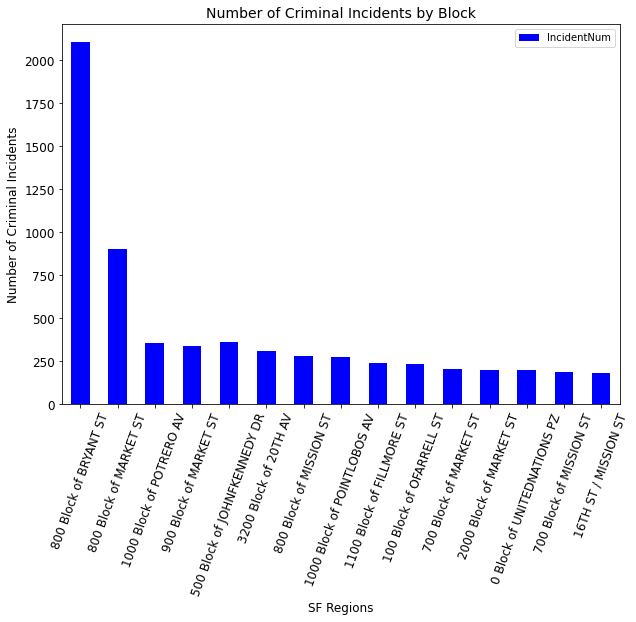

<Figure size 432x288 with 0 Axes>

In [21]:
#plot dataframe
crimes_reg_plot = region_df.plot.bar(figsize=(10,7), color='b',fontsize = 12) 

# Set the xlabel and ylabel using class methods
crimes_reg_plot.set_xlabel("SF Regions",fontsize = 12)
crimes_reg_plot.set_ylabel("Number of Criminal Incidents",fontsize = 12)
plt.title("Number of Criminal Incidents by Block",fontsize = 14)
plt.xticks(rotation = 70)
plt.show()
plt.tight_layout()

What is the distribution of crime by police district?

In [22]:
crime_dis_df = sfpd_incnum.groupby("PdDistrict")

count_crimes = crime_dis_df["PdDistrict"].count()

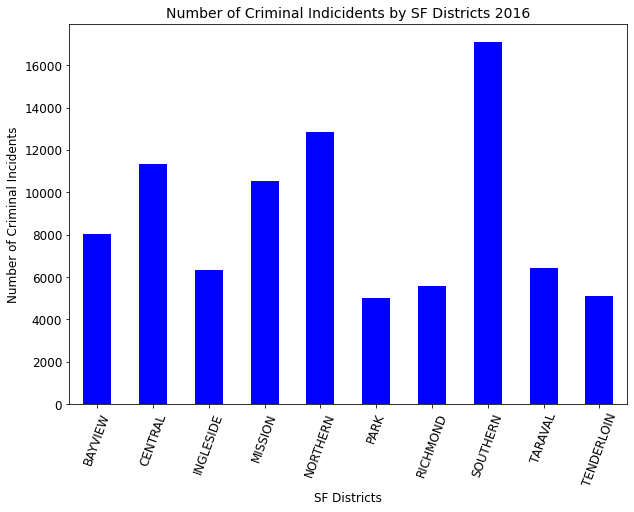

<Figure size 432x288 with 0 Axes>

In [23]:
crimes_plot = count_crimes.plot.bar(figsize=(10,7), color='b',fontsize = 12) 

# Set the xlabel and ylabel using class methods
crimes_plot.set_xlabel("SF Districts",fontsize = 12)
crimes_plot.set_ylabel("Number of Criminal Incidents",fontsize = 12)
plt.title("Number of Criminal Indicidents by SF Districts 2016",fontsize = 14)
plt.xticks(rotation = 70)
plt.show()
plt.tight_layout()

Where and what time do criminal incidents occur? We visualize this with a map for each of three times of day: morning (12am-8am), middle(8am-5pm), and night(5pm-12am).

In [2]:
morning_crime = sfpd_incnum.loc[sfpd_clean["Time of Day"]== "Morning"]
middle_crime = sfpd_incnum.loc[sfpd_clean["Time of Day"]== "Middle"]
night_crime = sfpd_incnum.loc[sfpd_clean["Time of Day"]== "Night"]

NameError: name 'sfpd_incnum' is not defined

In [ ]:
#morning crime map
gmaps.configure(api_key=g_key)

locations = morning_crime[["Y", "X"]].astype(float)
IncidntNum = morning_crime['IncidntNum']

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=IncidntNum, 
                                 dissipating=True, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

In [ ]:
#day crime map
gmaps.configure(api_key=g_key)

locations = middle_crime[["Y", "X"]].astype(float)
IncidntNum = middle_crime['IncidntNum']
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=IncidntNum, 
                                 dissipating=True, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

In [ ]:
#night crime map
gmaps.configure(api_key=g_key)

locations = night_crime[["Y", "X"]].astype(float)
IncidntNum = night_crime['IncidntNum']

fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=IncidntNum, 
                                 dissipating=True, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig